## Load data and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load training and testing data
train_data = pd.read_csv('archive/fashion-mnist_train.csv')
test_data = pd.read_csv('archive/fashion-mnist_test.csv')
train_data.shape, test_data.shape

((60000, 785), (10000, 785))

In [3]:
# Check for missing values
train_data.isnull().sum().sum(), test_data.isnull().sum().sum()

(0, 0)

In [4]:
# Check for duplicate values
train_data.duplicated().sum(), test_data.duplicated().sum()

(43, 1)

In [5]:
# Find the indices of duplicate rows
duplicated_indices_train = train_data[train_data.duplicated(keep=False)].index
duplicated_indices_test = test_data[test_data.duplicated(keep=False)].index

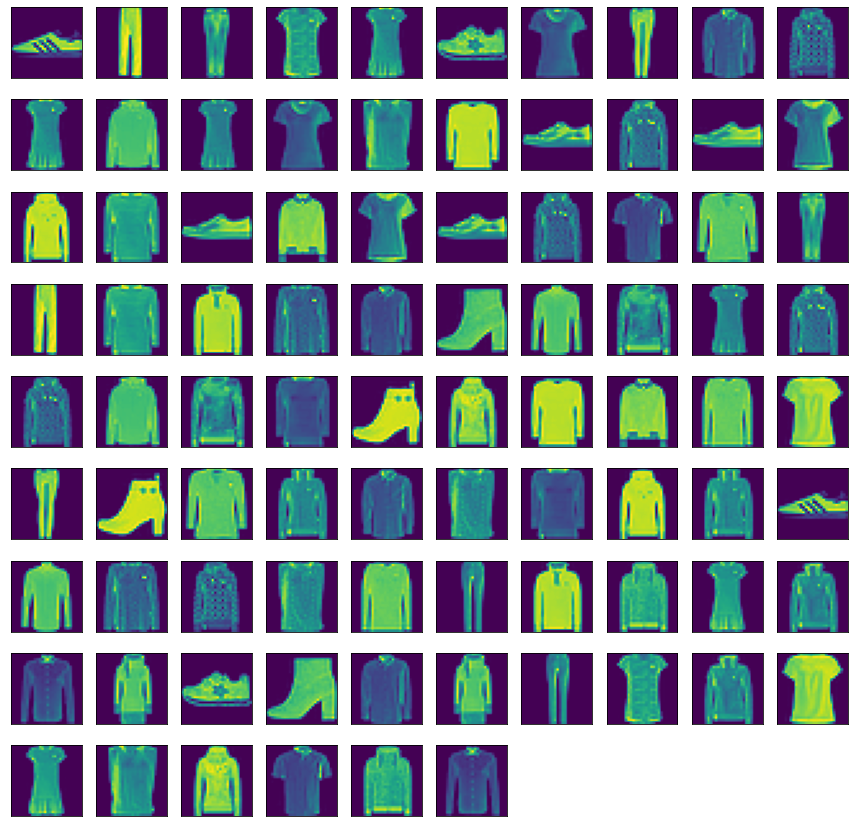

In [6]:
# Plot duplicate images
plt.figure(figsize=(15, 15))
for i, index in enumerate(duplicated_indices_train):
    plt.subplot(9, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data.iloc[:, 1:].values.reshape(-1, 28, 28)[index])
plt.show()

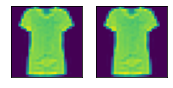

In [7]:
# Plot duplicate images
plt.figure(figsize=(15, 15))
for i, index in enumerate(duplicated_indices_test):
    plt.subplot(9, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_data.iloc[:, 1:].values.reshape(-1, 28, 28)[index])
plt.show()

In [8]:
# Drop duplicate data
train_data = train_data.drop_duplicates().reset_index(drop=True)
test_data = test_data.drop_duplicates().reset_index(drop=True)
train_data.shape, test_data.shape

((59957, 785), (9999, 785))

In [9]:
# Separate image and label data
# Normalize image data by scaling these values to a [0,1]
train_images = train_data.iloc[:, 1:]/255.0
train_labels = train_data.iloc[:, 0]

test_images = test_data.iloc[:, 1:]/255.0
test_labels = test_data.iloc[:, 0]

# Print the shape of the loaded data
print("Train Images shape:", train_images.shape)
print("Train Labels shape:", train_labels.shape)
print("Test Images shape:", test_images.shape)
print("Test Labels shape:", test_labels.shape)

Train Images shape: (59957, 784)
Train Labels shape: (59957,)
Test Images shape: (9999, 784)
Test Labels shape: (9999,)


## Exploratory data analysis

In [10]:
# Map each image to a single label
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

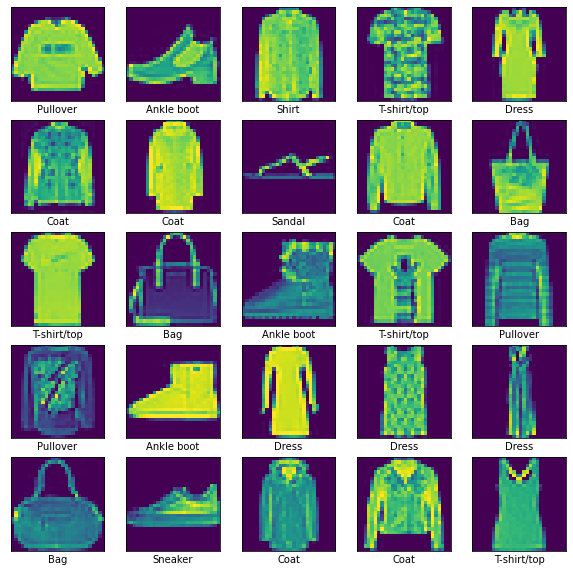

In [11]:
# Display sample images and the class names of training data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data.iloc[:, 1:].values.reshape(-1, 28, 28)[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [12]:
# Examine class distributions of training data
train_class_counts = np.bincount(train_labels)
train_class_names = [class_names[i] for i in range(len(train_class_counts))]
train_df = pd.DataFrame(data=train_class_counts, index=train_class_names, columns=['Train Count'])

# Examine class distributions of testing data
test_class_counts = np.bincount(test_labels)
test_class_names = [class_names[i] for i in range(len(test_class_counts))]
test_df = pd.DataFrame(data=test_class_counts, index=test_class_names, columns=['Test Count'])

# Concatenate the two DataFrames
pd.concat([train_df, test_df], axis=1).T

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
Train Count,5998,5996,5988,5997,5995,6000,5989,5996,6000,5998
Test Count,999,1000,1000,1000,1000,1000,1000,1000,1000,1000


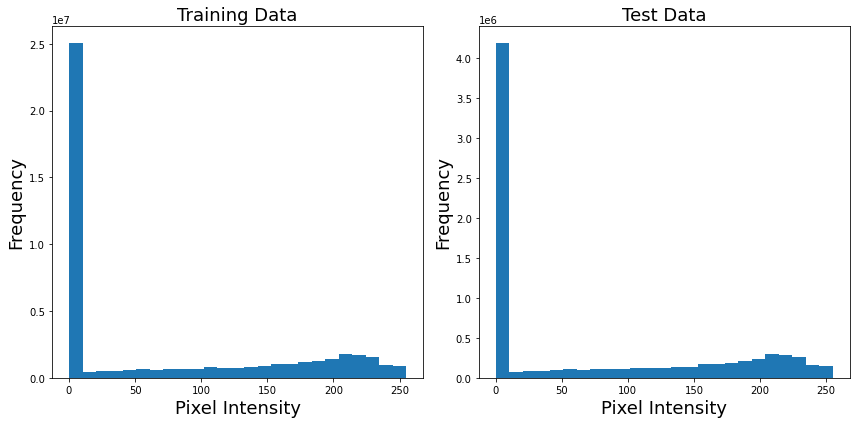

In [16]:
# Flatten the pixel values
train_pixel_values = train_data.drop(columns=['label']).values.flatten()
test_pixel_values = test_data.drop(columns=['label']).values.flatten()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot pixel intensity distribution for training data
axes[0].hist(train_pixel_values, bins=25)
axes[0].set_xlabel('Pixel Intensity', fontsize=18)
axes[0].set_ylabel('Frequency', fontsize=18)
axes[0].set_title('Training Data', fontsize=18)

# Plot pixel intensity distribution for test data
axes[1].hist(test_pixel_values, bins=25)
axes[1].set_xlabel('Pixel Intensity', fontsize=18)
axes[1].set_ylabel('Frequency', fontsize=18)
axes[1].set_title('Test Data', fontsize=18)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Feature engineering

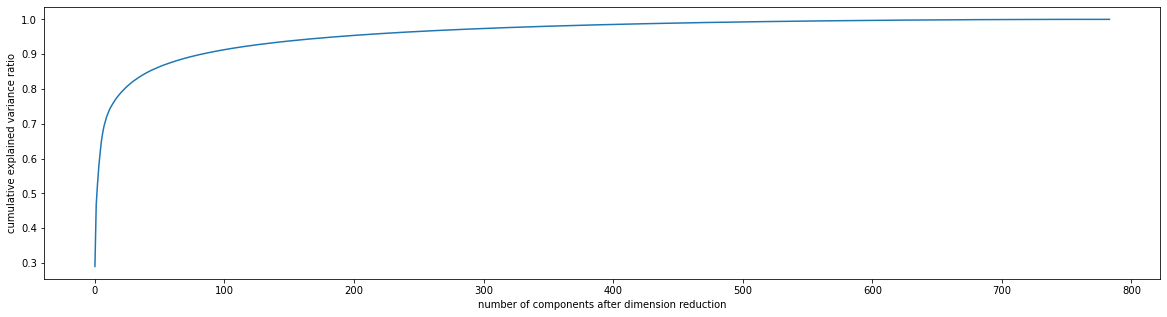

In [17]:
# Use PCA to conduct dimension reduction
from sklearn.decomposition import PCA

# Concatenate the training and test data
combined_images = np.concatenate((train_images, test_images), axis=0)

# Plot explained variance vs number of components
pca_line = PCA(random_state=2023).fit(combined_images)
plt.figure(figsize=[20,5])
plt.plot(np.cumsum(pca_line.explained_variance_ratio_))
plt.xlabel("number of components after dimension reduction")
plt.ylabel("cumulative explained variance ratio")
plt.show()

In [18]:
# Find the minimum number of components where explained variance is greater than 0.95
cumsum = np.cumsum(pca_line.explained_variance_ratio_)
num_components = np.argwhere(cumsum > 0.95).min() + 1
print("Number of components for cumulative sum > 0.95:", num_components)

Number of components for cumulative sum > 0.95: 188


In [19]:
# Apply PCA on the combined data to do dimension reduction
pca = PCA(n_components=188, random_state=2023)
combined_images_pca = pca.fit_transform(combined_images)

# Split the transformed data back into training and test sets
train_images = pd.DataFrame(combined_images_pca[:len(train_images)])
test_images = pd.DataFrame(combined_images_pca[len(train_images):])

# Print the shape of the data after dimension reduction
print("Train Images shape:", train_images.shape)
print("Test Images shape:", test_images.shape)

Train Images shape: (59957, 188)
Test Images shape: (9999, 188)


## Random forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [21]:
rfc = RandomForestClassifier(n_estimators=200,random_state=2023)

In [23]:
import time
start = time.time()
rfc.fit(train_images,train_labels)
end = time.time()
forest_time = end-start

In [24]:
forest_time

184.60518288612366

In [106]:
cross_val_score(rfc,train_images,train_labels,cv=10).mean()

0.8679719646291856

In [25]:
train_labels_pred = rfc.predict(train_images)
test_labels_pred = rfc.predict(test_images)
random_forest_train = metrics.accuracy_score(train_labels,train_labels_pred)
random_forest_accuracy = metrics.accuracy_score(test_labels, test_labels_pred)

print("Train Accuracy score: {}".format(random_forest_train))
print("Test Accuracy score: {}".format(random_forest_accuracy))
print(metrics.classification_report(test_labels, test_labels_pred))

Train Accuracy score: 1.0
Test Accuracy score: 0.8665866586658666
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       999
           1       0.99      0.96      0.98      1000
           2       0.79      0.80      0.80      1000
           3       0.89      0.91      0.90      1000
           4       0.79      0.86      0.82      1000
           5       0.92      0.91      0.92      1000
           6       0.73      0.57      0.64      1000
           7       0.91      0.90      0.90      1000
           8       0.94      0.96      0.95      1000
           9       0.91      0.94      0.93      1000

    accuracy                           0.87      9999
   macro avg       0.87      0.87      0.86      9999
weighted avg       0.87      0.87      0.86      9999



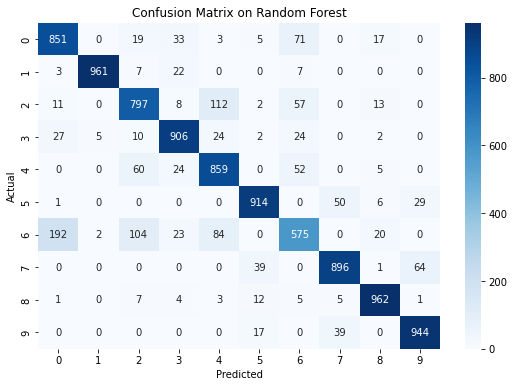

In [27]:
con_matrix = pd.crosstab(pd.Series(test_labels.values.flatten(), name='Actual' ),pd.Series(test_labels_pred, name='Predicted'))
plt.figure(figsize = (9,6))
plt.title("Confusion Matrix on Random Forest")
sns.heatmap(con_matrix, cmap="Blues", annot=True, fmt='g')
plt.show()

## Multinomial Logistic Regression

In [28]:
# Load all packages
from sklearn import linear_model, model_selection, metrics
import seaborn as sns
from tabulate import tabulate

In [31]:
# Split the PCA data into train and test
x_train_pca = train_images
x_test_pca = test_images
y_train = train_labels
y_test = test_labels
# Reference: http://ufldl.stanford.edu/tutorial/supervised/SoftmaxRegression/
# Model: Multinomial Logistic Regression (Softmax Regression)
# Data: PCA data
# Fit: 3-fold CV to train the model tune the hyperparameter
# Model formula: logit = X * beta, softmax for probability assignment
# Regularization: L2 norm, ridge regression
# Loss function: Cross-entropy loss + L2 Regularizer
# Score: the classification accuracy of all labels
# Tuned hyperparameter: regularization coefficient = 1/C = 1/1 = 1

parameters = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
log_reg = linear_model.LogisticRegression(penalty='l2', multi_class='multinomial',
                                          fit_intercept=True, tol=1e-4, max_iter=10000)
clf = model_selection.GridSearchCV(log_reg, parameters, scoring='accuracy', cv=3, return_train_score=True)
clf.fit(x_train_pca, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=10000,
                                          multi_class='multinomial'),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
             return_train_score=True, scoring='accuracy')

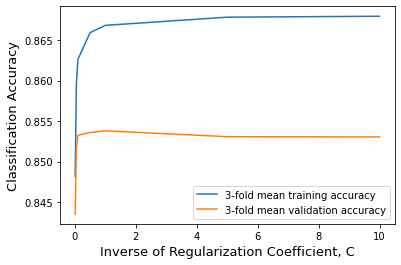

In [34]:
# Plot the hyperparameter tuning curve
cv_mean_train_accuracy = clf.cv_results_['mean_train_score']
cv_mean_test_accuracy = clf.cv_results_['mean_test_score']
plt.plot(parameters['C'], cv_mean_train_accuracy, label='3-fold mean training accuracy')
plt.plot(parameters['C'], cv_mean_test_accuracy, label='3-fold mean validation accuracy')
plt.xlabel('Inverse of Regularization Coefficient, C', fontsize=13)
plt.ylabel('Classification Accuracy', fontsize=13)
plt.legend()
# plt.savefig("fig/logistic-regression-regularization-coefficient-tuning.png")

In [35]:
# Final model with PCA data
log_reg_pca = linear_model.LogisticRegression(penalty='l2', multi_class='multinomial',
C=clf.best_params_['C'], fit_intercept=True, tol=1e-4, max_iter=10000)
start = time.time()
log_reg_pca.fit(x_train_pca, y_train)
end = time.time()
log_reg_pca_runtime = end - start
log_reg_pca_train_accuracy = log_reg_pca.score(x_train_pca, y_train)
log_reg_pca_test_accuracy = log_reg_pca.score(x_test_pca, y_test)

In [39]:
# Split the original un-PCAed data into train and test
x_train_orig = train_data/255.0
x_test_orig = test_data/255.0

# Final model with original data
log_reg_orig = linear_model.LogisticRegression(penalty='l2', multi_class='multinomial',
C=clf.best_params_['C'], fit_intercept=True, tol=1e-4, max_iter=10000)
start = time.time()
log_reg_orig.fit(x_train_orig, y_train)
end = time.time()
log_reg_orig_runtime = end - start
log_reg_orig_train_accuracy = log_reg_orig.score(x_train_orig, y_train)
log_reg_orig_test_accuracy = log_reg_orig.score(x_test_orig, y_test)
table = [['Logistic regression', 'With PCA data', 'With original data'],
['Training set accuracy', log_reg_pca_train_accuracy, log_reg_orig_train_accuracy],
['Test set accuracy', log_reg_pca_test_accuracy, log_reg_orig_test_accuracy],
['Model training time (sec)', log_reg_pca_runtime, log_reg_orig_runtime]]
print(tabulate(table))

-------------------------  ------------------  ------------------
Logistic regression        With PCA data       With original data
Training set accuracy      0.86491985923245    0.8966926297179646
Test set accuracy          0.8574857485748575  0.8687868786878687
Model training time (sec)  37.250686168670654  173.78548097610474
-------------------------  ------------------  ------------------


Text(60.0, 0.5, 'Actual')

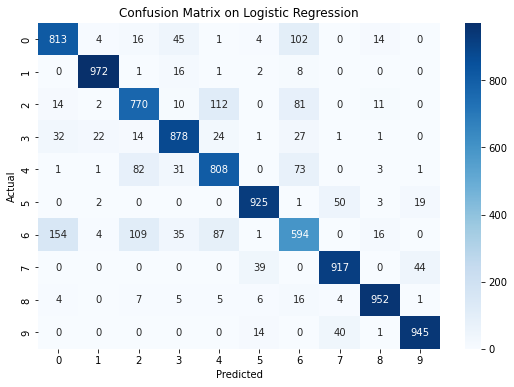

In [38]:
# Confusion matrix
con_matrix = metrics.confusion_matrix(y_test, log_reg_pca.predict(x_test_pca))
plt.figure(figsize = (9,6))
plt.title("Confusion Matrix on Logistic Regression")
sns.heatmap(con_matrix, cmap="Blues", annot=True, fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")